# Importing

In [1]:
import sys
sys.executable

'/home/sarah/Documentos/PSGCode/psg-venv/bin/python'

In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
from geexhp import datasetup as dset

import tensorflow as tf
from geexhp import cnn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import corner
import matplotlib.pyplot as plt
from PIL import ImageFont
from tensorflow.keras.utils import plot_model # type: ignore
import visualkeras
from geexhp import datavis
datavis.configure_matplotlib()


# Data Setup

In [4]:
#folder = "../parallel/data/"
#df = dset.combine_parquet(folder=folder, keyword="_", output_file=True)

In [3]:
df = pd.read_parquet("../data/__data.parquet")

In [4]:
df.columns.tolist()

['WAVELENGTH',
 'ALBEDO',
 'OBJECT',
 'OBJECT-NAME',
 'OBJECT-DATE',
 'OBJECT-DIAMETER',
 'OBJECT-GRAVITY',
 'OBJECT-GRAVITY-UNIT',
 'OBJECT-STAR-DISTANCE',
 'OBJECT-STAR-VELOCITY',
 'OBJECT-SOLAR-LONGITUDE',
 'OBJECT-SOLAR-LATITUDE',
 'OBJECT-SEASON',
 'OBJECT-STAR-TYPE',
 'OBJECT-STAR-TEMPERATURE',
 'OBJECT-STAR-RADIUS',
 'OBJECT-OBS-LONGITUDE',
 'OBJECT-OBS-LATITUDE',
 'OBJECT-OBS-VELOCITY',
 'OBJECT-PERIOD',
 'OBJECT-INCLINATION',
 'GEOMETRY',
 'GEOMETRY-OFFSET-NS',
 'GEOMETRY-OFFSET-EW',
 'GEOMETRY-OFFSET-UNIT',
 'GEOMETRY-OBS-ALTITUDE',
 'GEOMETRY-ALTITUDE-UNIT',
 'GEOMETRY-USER-PARAM',
 'GEOMETRY-STELLAR-TYPE',
 'GEOMETRY-STELLAR-TEMPERATURE',
 'GEOMETRY-STELLAR-MAGNITUDE',
 'GEOMETRY-SOLAR-ANGLE',
 'GEOMETRY-OBS-ANGLE',
 'GEOMETRY-PLANET-FRACTION',
 'GEOMETRY-STAR-DISTANCE',
 'GEOMETRY-STAR-FRACTION',
 'GEOMETRY-REF',
 'GEOMETRY-DISK-ANGLES',
 'GEOMETRY-ROTATION',
 'GEOMETRY-AZIMUTH',
 'GEOMETRY-BRDFSCALER',
 'ATMOSPHERE-DESCRIPTION',
 'ATMOSPHERE-STRUCTURE',
 'ATMOSPHERE-WEIGH

In [6]:
dfabun = dset.extract_abundances(df)
dfabun.dropna(inplace=True)

# Preprocessing data and creating the training and testing datasets

In [7]:
# Define inputs and outputs
inputs = 'ALBEDO'
outputs_list = ['OBJECT-DIAMETER', 'OBJECT-GRAVITY', 'ATMOSPHERE-PRESSURE', 'ATMOSPHERE-TEMPERATURE',
                'C2H6', 'CH4', 'CO', 'CO2', 'H2', 'H2O', 'HCN', 'N2',
                'N2O', 'NH3', 'O2', 'O3', 'PH3']

# 2. Split the Data
# Prepare inputs
X = np.stack(dfabun[inputs].values)
# Prepare outputs
y = dfabun[outputs_list].copy()

# Extract stratification labels
stratify_labels = dfabun["Earth_type"]

In [8]:
# Initial train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=dfabun["Earth_type"])

# Get the indices of the training data
train_indices = y_train.index

# Get stratify labels for training data
stratify_train_labels = dfabun.loc[train_indices, "Earth_type"]

# Perform train-validation split with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=stratify_train_labels)

In [9]:
# 3. Normalize the Data
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

num_features = len(outputs_list)
y_scalers = []
y_train_scaled = np.zeros_like(y_train)
y_val_scaled = np.zeros_like(y_val)
y_test_scaled = np.zeros_like(y_test)

for i in range(num_features):
    scaler = StandardScaler()
    y_train_scaled[:, i] = scaler.fit_transform(y_train.to_numpy()[:, i].reshape(-1, 1)).ravel()
    y_val_scaled[:, i] = scaler.transform(y_val.to_numpy()[:, i].reshape(-1, 1)).ravel()
    y_test_scaled[:, i] = scaler.transform(y_test.to_numpy()[:, i].reshape(-1, 1)).ravel()
    y_scalers.append(scaler)

In [10]:
# 6. Reshape inputs for CNN
X_train_scaled = X_train_scaled[..., np.newaxis]
X_val_scaled = X_val_scaled[..., np.newaxis]
X_test_scaled = X_test_scaled[..., np.newaxis]

input_shape = X_train_scaled.shape[1:]  # (sequence_length, 1)
output_units = y_train_scaled.shape[1]  # Number of outputs

In [11]:
y_train_dict = {output_name: y_train_scaled[:, idx] for idx, output_name in enumerate(outputs_list)}
y_val_dict = {output_name: y_val_scaled[:, idx] for idx, output_name in enumerate(outputs_list)}
y_test_dict = {output_name: y_test_scaled[:, idx] for idx, output_name in enumerate(outputs_list)}

In [12]:
batch_size = 32

def _parse_function(x, y):
    x = tf.cast(x, tf.float32)
    y = {key: tf.cast(value, tf.float32) for key, value in y.items()}
    return x, y

# Training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_dict))
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val_dict))
validation_dataset = validation_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(batch_size)
validation_dataset = validation_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_dict))
test_dataset = test_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Convolutional Neural Network 1D (CNN) with tuning hyperparameters

In [13]:
# Instantiate the HyperTuningBayCNN class
cnn_tuner = cnn.HyperTuningBayCNN(input_shape, output_units, outputs_list)

In [26]:
# Perform hyperparameter search
best_hps = cnn_tuner.search(train_dataset, validation_dataset, max_trials=2, search_epochs=1)

Trial 2 Complete [00h 07m 28s]
val_loss: 17.216766357421875

Best val_loss So Far: 12.679478645324707
Total elapsed time: 00h 15m 15s


In [27]:
# Fit the best model
best_model, history = cnn_tuner.fit_best_model(train_dataset, validation_dataset, epochs=5, patience=5)

Epoch 1/5
795/795 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - ATMOSPHERE-PRESSURE_loss: 19.3683 - ATMOSPHERE-TEMPERATURE_loss: 11.7471 - C2H6_loss: 29.9967 - CH4_loss: 8.1195 - CO2_loss: 15.9869 - CO_loss: 9.1804 - H2O_loss: 17.5828 - H2_loss: 72.2827 - HCN_loss: 20.5402 - N2O_loss: 9.2093 - N2_loss: 11.8529 - NH3_loss: 14.5021 - O2_loss: 17.0780 - O3_loss: 29.5847 - OBJECT-DIAMETER_loss: 11.7500 - OBJECT-GRAVITY_loss: 28.0186 - PH3_loss: 11.8056 - loss: 338.6329Stopping training manually...
795/795 ━━━━━━━━━━━━━━━━━━━━ 592s 739ms/step - ATMOSPHERE-PRESSURE_loss: 19.3497 - ATMOSPHERE-TEMPERATURE_loss: 11.7364 - C2H6_loss: 29.9674 - CH4_loss: 8.1122 - CO2_loss: 15.9716 - CO_loss: 9.1723 - H2O_loss: 17.5660 - H2_loss: 72.2094 - HCN_loss: 20.5201 - N2O_loss: 9.2015 - N2_loss: 11.8417 - NH3_loss: 14.4884 - O2_loss: 17.0618 - O3_loss: 29.5554 - OBJECT-DIAMETER_loss: 11.7394 - OBJECT-GRAVITY_loss: 27.9909 - PH3_loss: 11.7944 - loss: 338.3058 - val_ATMOSPHERE-PRESSURE_loss: 0.6267 - val_ATMOSPHERE-T

In [28]:
cnn_tuner.save("model.keras")

Model saved at model.keras


In [62]:
cnn_tuner.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 2304, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 2296, 96)  │        960 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 2288, 96)  │     83,040 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 1144, 96)  │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1144, 96)  │        384 │ max_pooling1d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout_4        │ (None, 1144, 96)  │          0 │ batch_normalizat… │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 1142, 16)  │      4,624 │ mc_dropout_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 1140, 16)  │        784 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 570, 16)   │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 570, 16)   │         64 │ max_pooling1d_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout_5        │ (None, 570, 16)   │          0 │ batch_normalizat… │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 9120)      │          0 │ mc_dropout_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 448)       │  4,086,208 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout_6        │ (None, 448)       │          0 │ dense_2[0][0]     │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ATMOSPHERE-PRESSURE │ (None, 1)         │        449 │ mc_dropout_6[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ATMOSPHERE-TEMPERA… │ (None, 1)         │        449 │ mc_dropout_6[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C2H6 (Dense)        │ (None, 1)         │        449 │ mc_dropout_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CH4 (Dense)         │ (None, 1)         │        449 │ mc_dropout_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CO (Dense)          │ (None, 1)         │        449 │ mc_dropout_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CO2 (Dense)         │ (None, 1)         │        449 │ mc_dropout_6[0][

 Total params: 12,550,644 (47.88 MB)

 Trainable params: 4,183,473 (15.96 MB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 8,366,947 (31.92 MB)

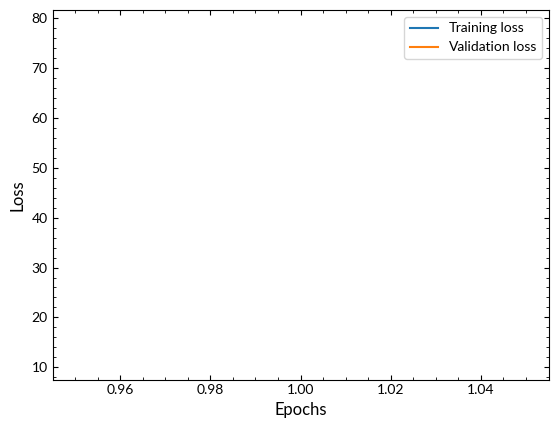

In [30]:
cnn_tuner.plot_losses()

In [14]:
cnn_tuner.load_model("model.keras")

Model loaded from model.keras


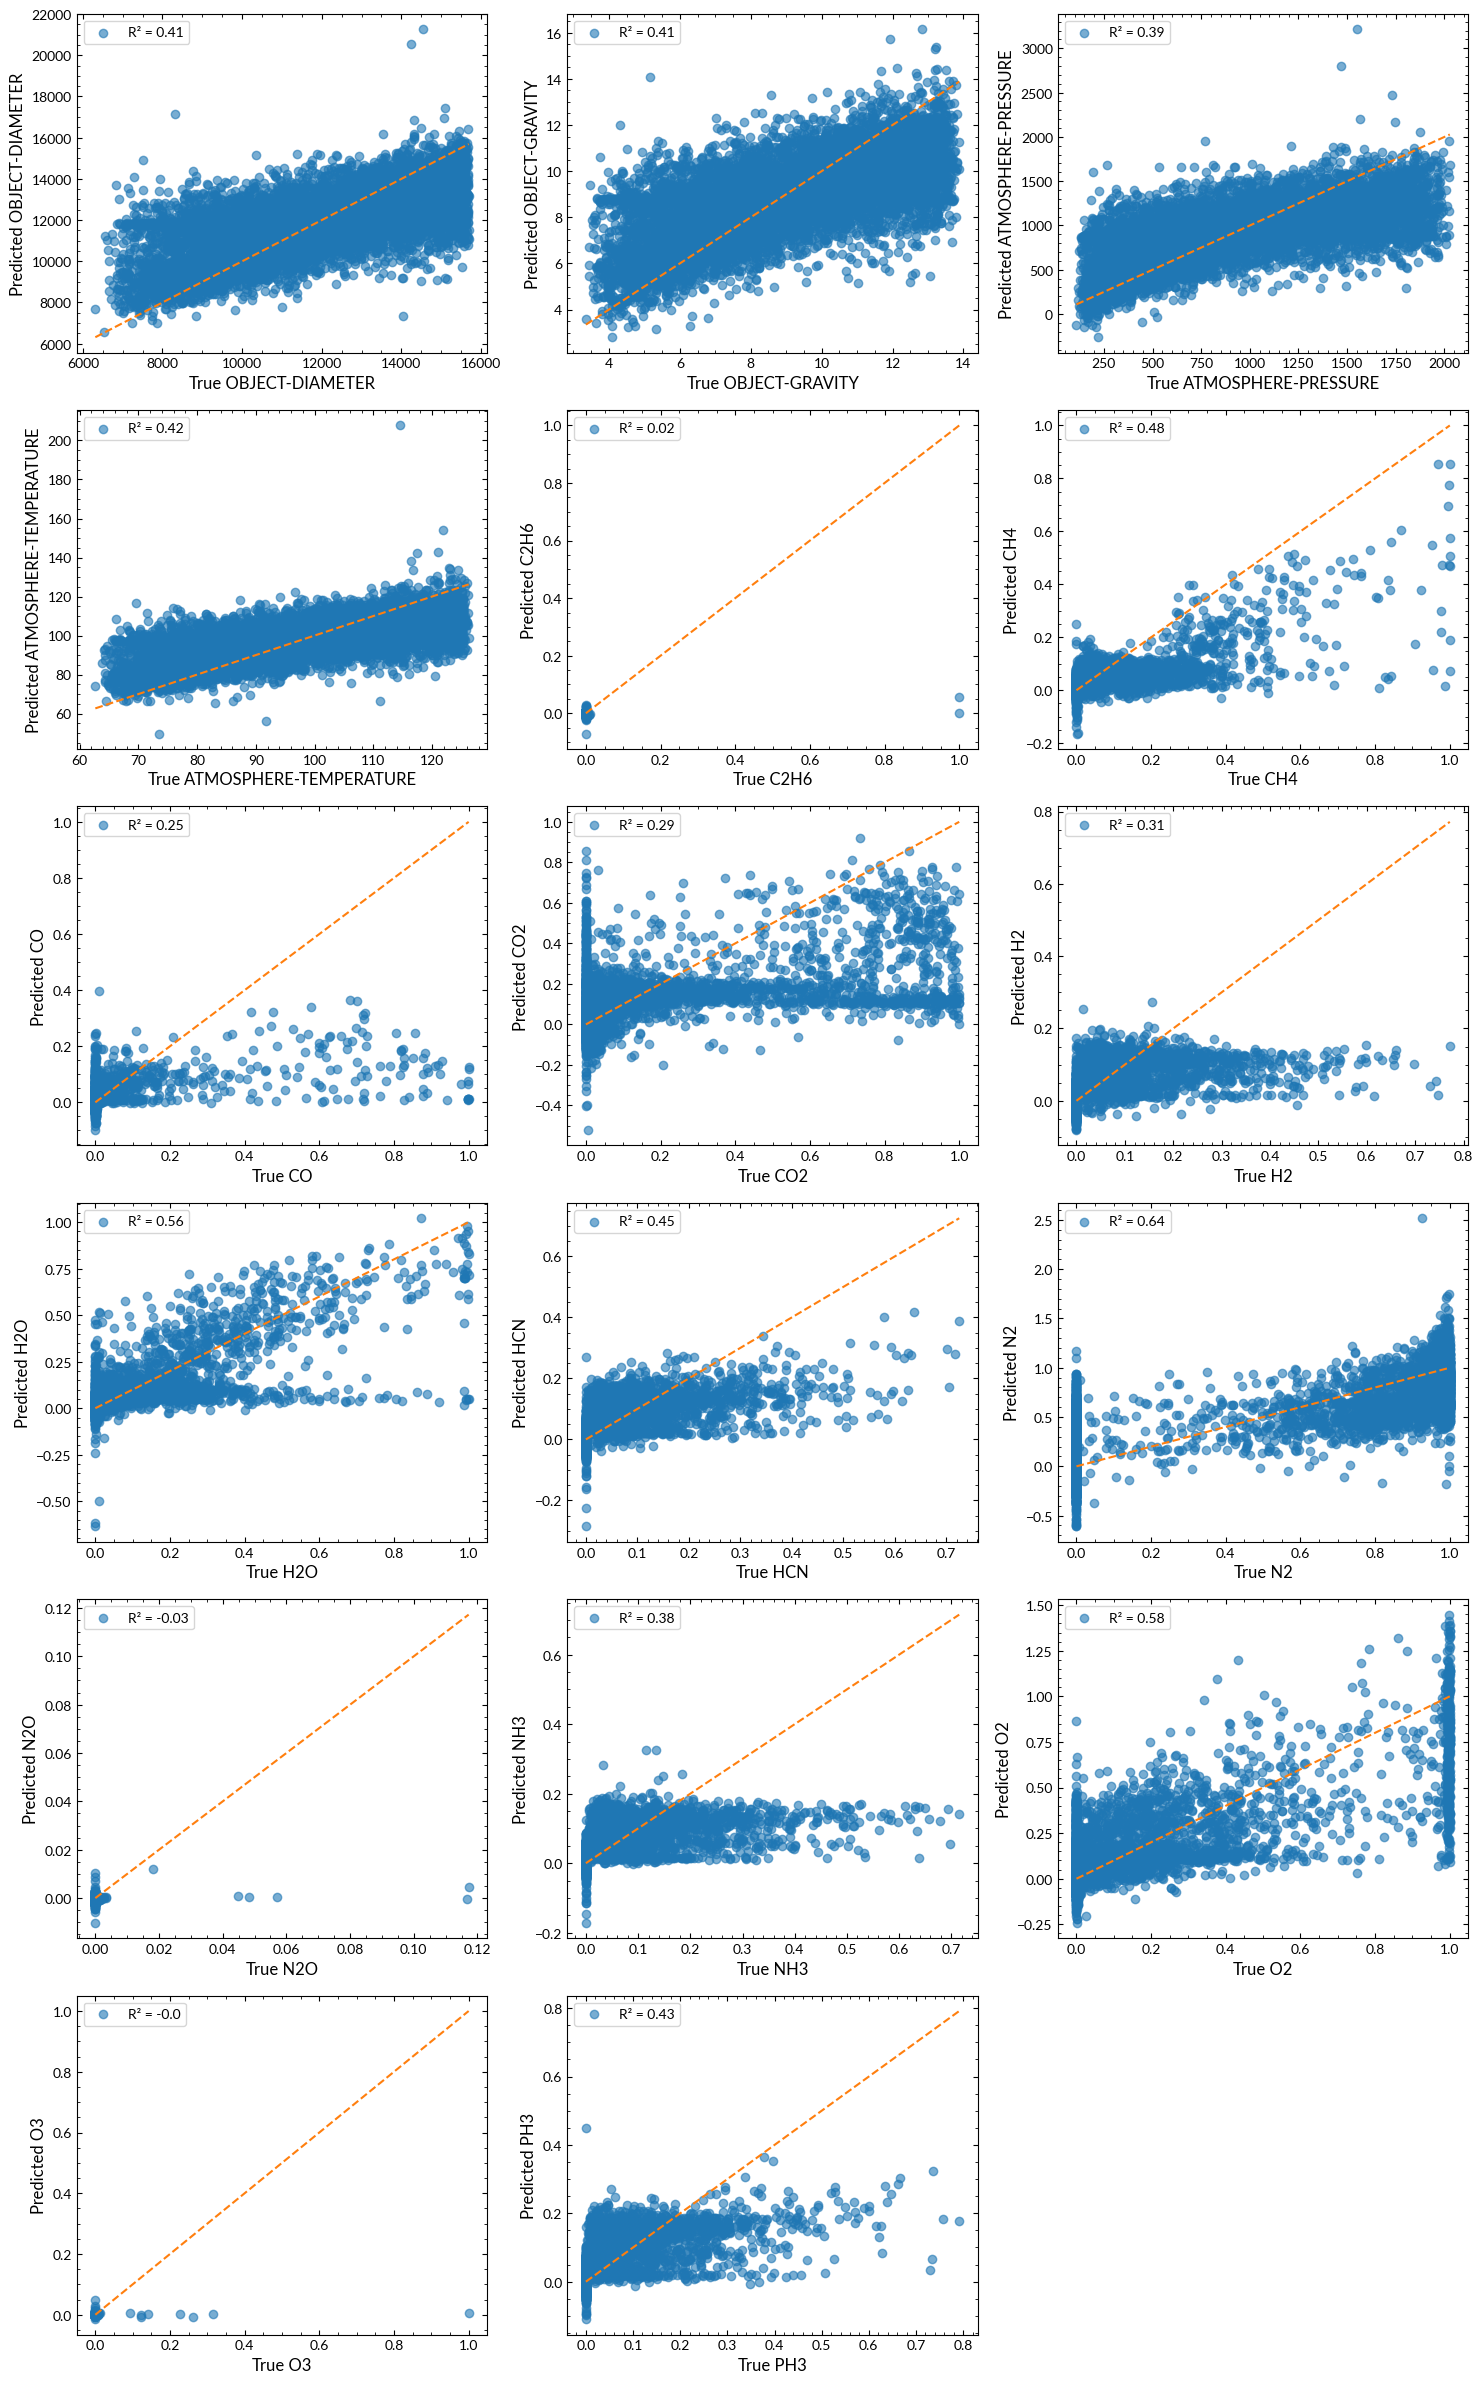

In [31]:
results = cnn_tuner.evaluate(test_dataset, outputs_list, y_scalers, plot=True)

In [32]:
results

,R² scores,MAE scores,RMSE scores
OBJECT-DIAMETER,0.41,1397.109985,1785.880005
OBJECT-GRAVITY,0.41,1.620000,2.060000
ATMOSPHERE-PRESSURE,0.39,307.220001,391.989990
ATMOSPHERE-TEMPERATURE,0.42,9.670000,12.240000
C2H6,0.02,0.000000,0.020000
CH4,0.48,0.040000,0.080000
CO,0.25,0.020000,0.080000
CO2,0.29,0.120000,0.190000
H2,0.31,0.030000,0.070000
H2O,0.56,0.050000,0.090000


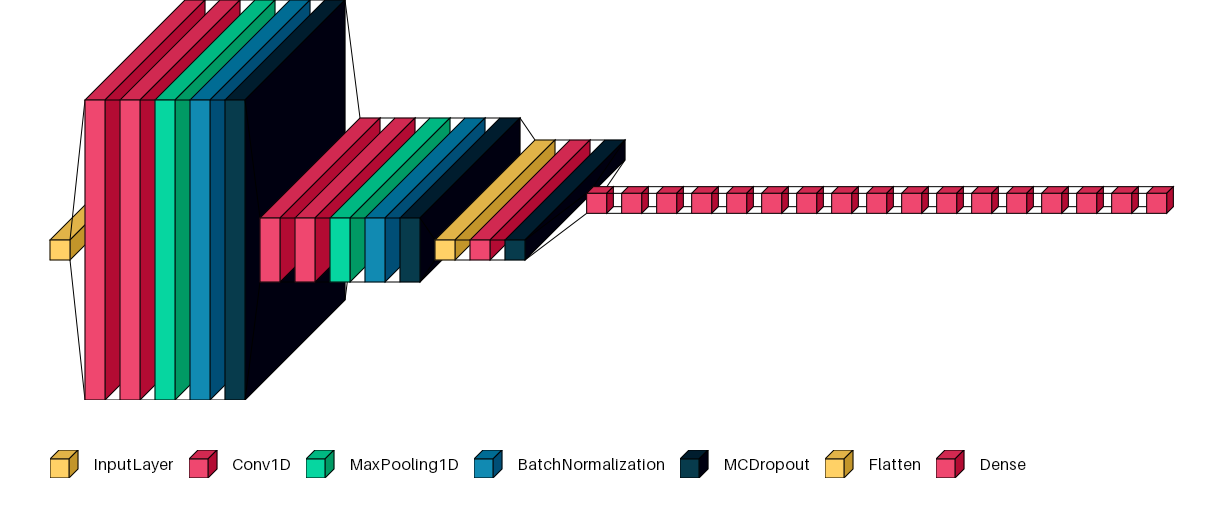

In [57]:
font = ImageFont.load_default(size = 16)

visualkeras.layered_view(cnn_tuner.best_model, to_file='../images/model_architecture.png', legend=True,
                        draw_funnel=True, draw_volume=True,
                        one_dim_orientation="x", max_xy=300, max_z=100, font=font, padding=50, spacing=15, shade_step=30)

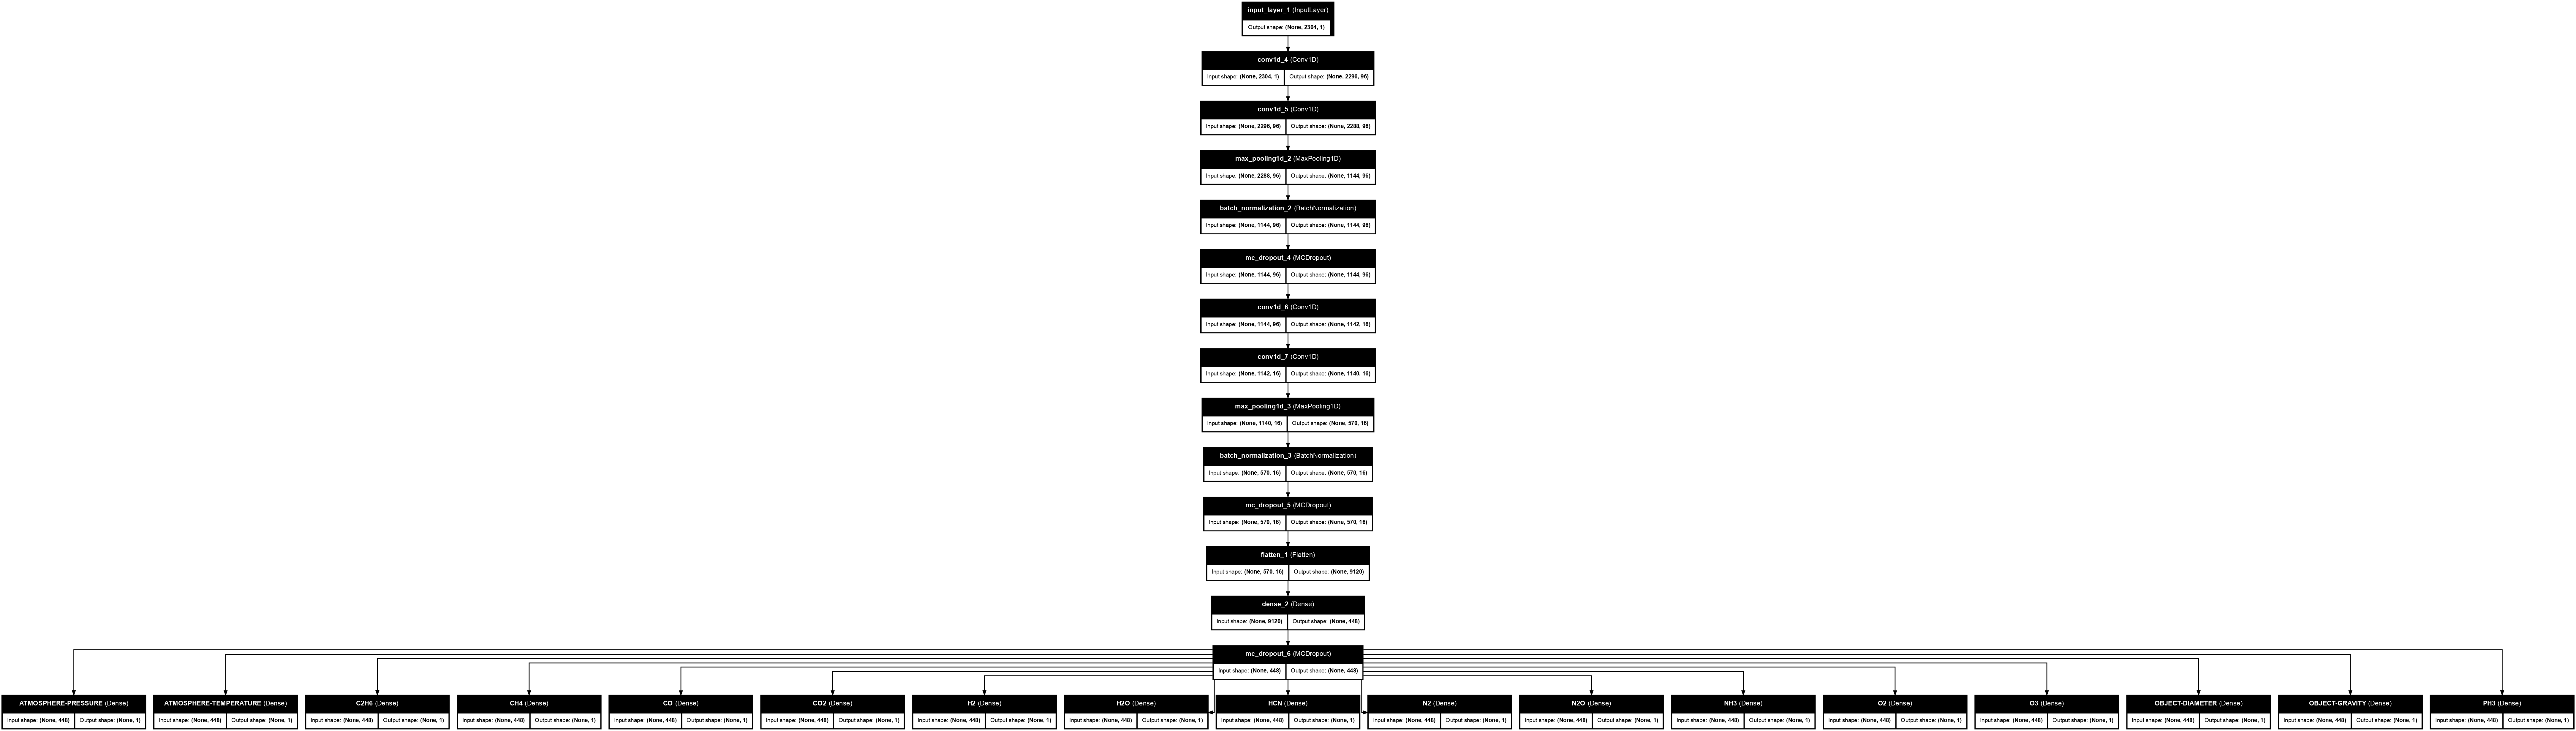

In [61]:
plot_model(cnn_tuner.best_model, to_file='../images/model.png', show_shapes=True, show_layer_names=True,  rankdir='TB', dpi=100)

# Stochastic predictions

In [47]:
num_samples = 1 

# Selecionar indices aleatórios
indices = np.random.choice(X_test_scaled.shape[0], size=num_samples, replace=False)

# Selecionar o subconjunto
X_test_subset = X_test_scaled[indices]
y_test_subset = y_test_scaled[indices]

In [49]:
# Número de iterações para Monte Carlo Dropout
n_iter = 100

# Obter predições com incerteza para o subconjunto
predictions_dict = cnn_tuner.predict_with_uncertainty(X_test_subset, n_iter=n_iter)

In [50]:
# Inverter as transformações nas predições
predictions_inv_dict = {}

for idx, name in enumerate(cnn_tuner.outputs_list):
    preds = predictions_dict[name]  # shape: (n_iter, num_samples, 1)
    preds = preds.reshape(-1, 1)  # shape: (n_iter * num_samples, 1)

    # Inverter a normalização com o scaler correto
    preds_inv = y_scalers[idx].inverse_transform(preds)
    predictions_inv_dict[name] = preds_inv.flatten()

# Combinar predições
predictions_combined = np.column_stack([predictions_inv_dict[name] for name in cnn_tuner.outputs_list])

# Preparar os valores verdadeiros (para NumPy array)
y_test_dict = {name: y_test_subset[:, idx].reshape(-1, 1) for idx, name in enumerate(cnn_tuner.outputs_list)}
y_test_inv_dict = {}

for idx, name in enumerate(cnn_tuner.outputs_list):
    y_true_inv = y_scalers[idx].inverse_transform(y_test_dict[name])
    y_test_inv_dict[name] = y_true_inv.flatten()

# Repetir os valores verdadeiros para corresponder às predições
y_test_combined = np.column_stack([np.repeat(y_test_inv_dict[name], n_iter) for name in cnn_tuner.outputs_list])

# Calcular erros se desejar
errors_combined = predictions_combined - y_test_combined

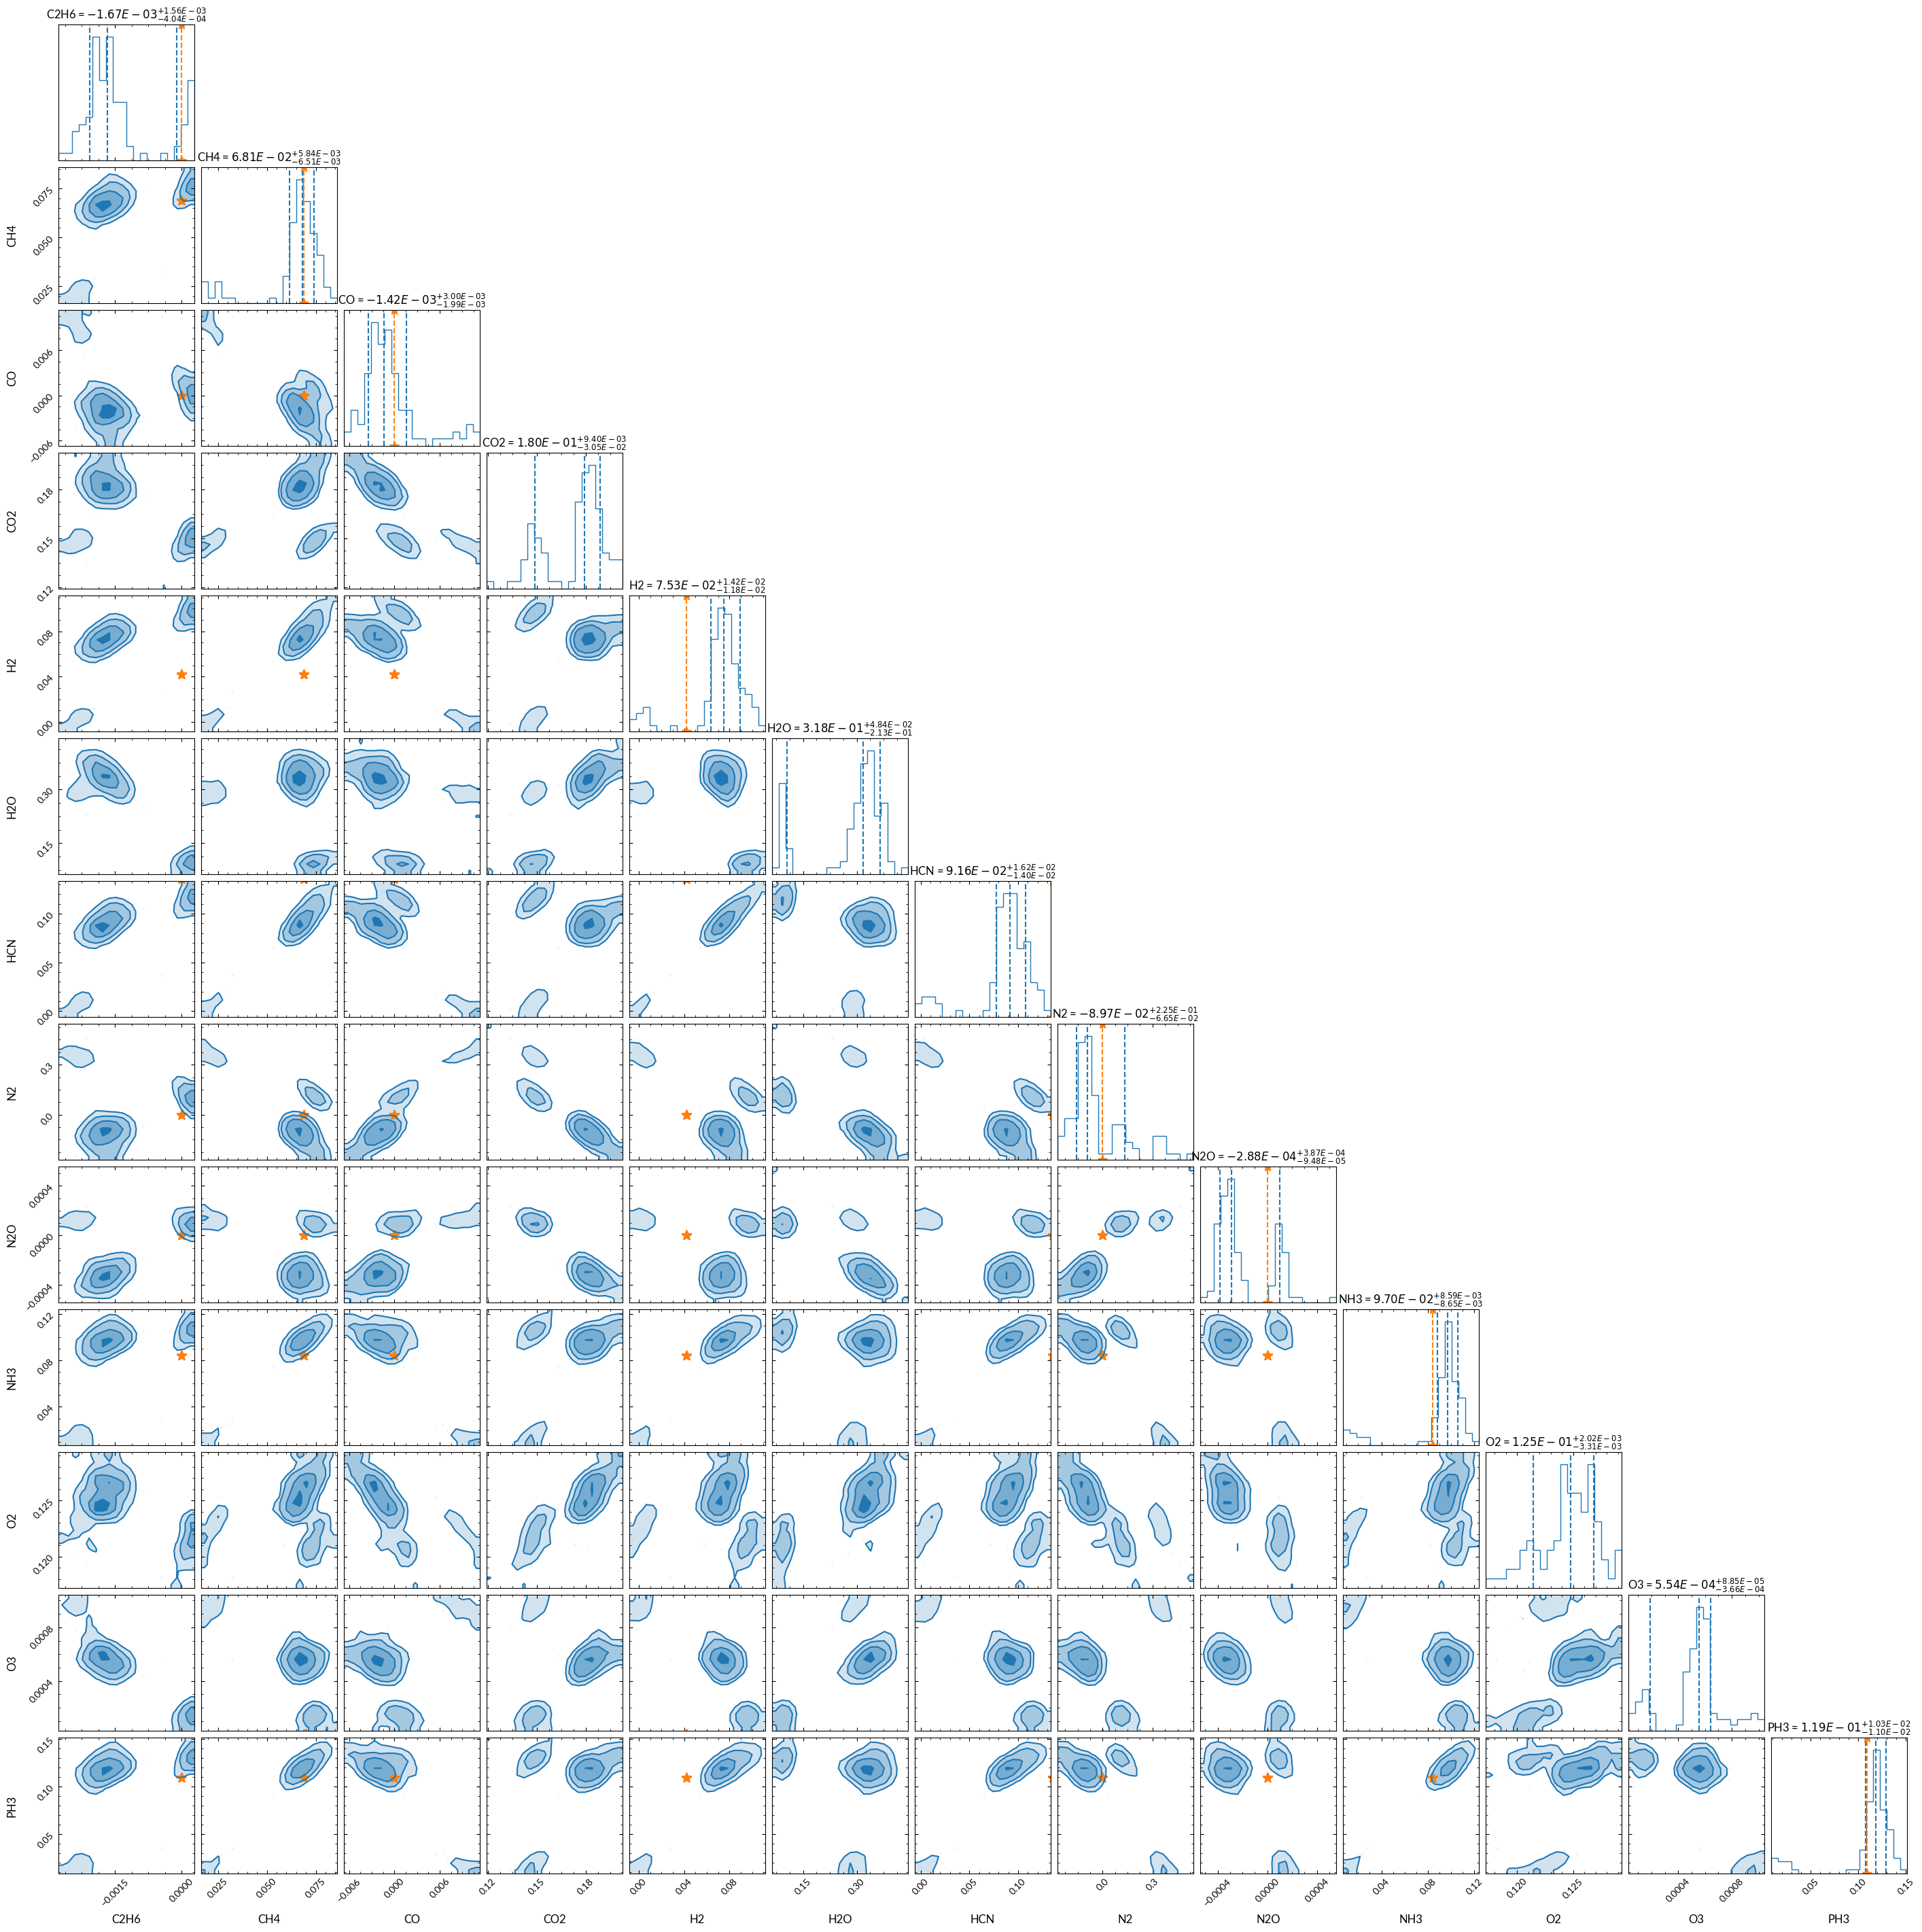

In [55]:
# Dados a serem plotados
data_to_plot = predictions_combined  # Ou 'errors_combined' se preferir plotar os erros

abundances = ['C2H6', 'CH4', 'CO', 'CO2', 'H2', 'H2O', 'HCN', 'N2', 'N2O', 'NH3', 'O2', 'O3', 'PH3']
abundance_indices = [cnn_tuner.outputs_list.index(name) for name in abundances]

# Selecionar parâmetros a serem plotados (opcional)
# param_indices = list(range(17)) 
data_to_plot = data_to_plot[:, abundance_indices]
feature_names_selected = [cnn_tuner.outputs_list[i] for i in abundance_indices]

# Plotting the corner plot with only the abundances in blue color
figure = corner.corner(
    data_to_plot,
    labels=feature_names_selected,
    show_titles=True,
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    title_fmt=".2E",
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 12},
    max_n_ticks=3,
    smooth=0.9,
    color='tab:blue'
)

# True values (to be plotted as star points)
true_values_to_plot = y_test_combined[:, abundance_indices]

# Add the true values as stars to the corner plot
axes = np.array(figure.axes).reshape((len(abundance_indices), len(abundance_indices)))

# Loop over the diagonal and off-diagonal subplots to add true values
for i in range(len(abundance_indices)):
    for j in range(i + 1):
        ax = axes[i, j]
        if i == j:  # Diagonal plot (histogram)
            ax.axvline(true_values_to_plot[0, i], color='tab:orange', linestyle='--', marker='*', markersize=10)
        else:  # Off-diagonal plot (scatter)
            ax.scatter(true_values_to_plot[:, j], true_values_to_plot[:, i], color='tab:orange', marker='*', s=100)

plt.savefig('corner_plot_predictions.png')
plt.show()